In [1]:
# # This code demonstrates how to fine-tune Vision Transformer (ViT) and SWIN models on the CIFAR-10 dataset and apply Grad-CAM visualization.

# ## 1. Setup Environment

# !pip install torch torchvision timm pytorch-gradcam
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git
# #!pip show pytorch-gradcam
# #!ls /usr/local/lib/python3.11/dist-packages/


In [18]:
# pip install --upgrade pytorch-grad-campip install --upgrade pytorch-grad-cam

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pytorch-grad-campip (from versions: none)
ERROR: No matching distribution found for pytorch-grad-campip


In [27]:
## 2. Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import timm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm

import cv2


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置: {device}")

使用裝置: cuda:0


# 計算 CIFAR-10 的均值和標準差

In [4]:

# 先載入資料集而不進行正規化，只進行 ToTensor
temp_transform = transforms.Compose([
    transforms.ToTensor()
])

temp_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=temp_transform)
temp_trainloader = DataLoader(temp_trainset, batch_size=128, shuffle=False, num_workers=2)

mean = 0.
std = 0.
nb_samples = 0.
for data, _ in temp_trainloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("CIFAR-10 訓練集的均值:", mean)
print("CIFAR-10 訓練集的標準差:", std)

Files already downloaded and verified
CIFAR-10 訓練集的均值: tensor([0.4914, 0.4822, 0.4465])
CIFAR-10 訓練集的標準差: tensor([0.2023, 0.1994, 0.2010])


# Dataset

In [5]:
## 3. Data Preparation

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [6]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# CIFAR-10 的類別名稱
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# def imshow(img):
#     # ImageNet 的均值和標準差
#     mean=[0.4914, 0.4822, 0.4465]
#     std=[0.2023, 0.1994, 0.2010]
#     # 反正規化
#     # img 是 PyTorch Tensor，需要轉換為 NumPy array
#     # 首先將 C, H, W 轉為 H, W, C (matplotlib 需要這個格式)
#     img = img.numpy().transpose((1, 2, 0))
#     img = std * img + mean # 乘以標準差，加上均值
#     img = np.clip(img, 0, 1) # 將像素值裁剪到 0-1 範圍內，以防超出
#     plt.imshow(img)
#     plt.show()

# # 獲取一個批次的訓練圖片
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # 顯示圖片
# print('圖片的形狀 (batch_size, channels, height, width):', images.shape)
# print('圖片的標籤:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

# # 選擇要顯示的圖片數量 (例如顯示前 4 張)
# num_images_to_show = 4

# # 創建一個網格來顯示多張圖片
# fig, axes = plt.subplots(1, num_images_to_show, figsize=(10, 3)) # 調整 figsize 以獲得更好的視覺效果

# for i in range(num_images_to_show):
#     ax = axes[i]
#     # 將單張圖片轉換為 NumPy array 並反正規化
#     img = images[i]
#     mean_np = np.array(mean)
#     std_np = np.array(std)
#     img = img.numpy().transpose((1, 2, 0)) # PyTorch: (C, H, W) -> Matplotlib: (H, W, C)
#     img = std_np * img + mean_np
#     img = np.clip(img, 0, 1) # 確保像素值在 0 到 1 之間

#     ax.imshow(img) # 顯示圖片
#     ax.set_title(classes[labels[i]]) # 顯示圖片類別
#     ax.axis('off') # 關閉座標軸

# plt.tight_layout() # 自動調整子圖參數，使之填充整個圖形區域
# plt.show()

# Model

In [9]:
## 4. Model Setup

# Load pre-trained models
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)
# swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)


# Modify classification heads
# For ViT
vit_model.head = nn.Linear(vit_model.head.in_features, 10)

# For SWIN: Custom head with correct pooling and feature handling
# class SwinHead(nn.Module):
#     def __init__(self, in_channels, num_classes):
#         super(SwinHead, self).__init__()
#         self.global_pool = nn.AdaptiveAvgPool2d(1)  # Reduce [batch, C, H, W] to [batch, C, 1, 1]
#         self.fc = nn.Linear(in_channels, num_classes)  # Map to num_classes

#     def forward(self, x):
#         #print(f"Feature map shape before permute: {x.shape}")  # Debug
#         # Transpose from [batch, H, W, C] to [batch, C, H, W]
#         x = x.permute(0, 3, 1, 2)
#         #print(f"Feature map shape after permute: {x.shape}")  # Debug
#         x = self.global_pool(x)  # Shape: [batch, C, 1, 1]
#         x = x.flatten(1)  # Shape: [batch, C]
#         #print(f"Shape after flattening: {x.shape}")  # Debug
#         x = self.fc(x)  # Shape: [batch, num_classes]
#         return x

# Debug: Inspect SWIN model feature dimension
#dummy_input = torch.randn(1, 3, 224, 224).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
#swin_model.eval()
#with torch.no_grad():
#    feature_map = swin_model.forward_features(dummy_input)
#    print(f"SWIN feature map shape: {feature_map.shape}")

# Apply custom head to SWIN (assuming 1024 channels, adjusted if debug shows otherwise)
# swin_model.head = SwinHead(in_channels=1024, num_classes=10)
# swin_model.head = nn.Linear(swin_model.head.in_features, 10)


vit_model.to(device)
# swin_model.to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

c:\Users\user\anaconda3\envs\dl_final\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [10]:
# # 冷凍所有參數
# for param in swin_model.parameters():
#     param.requires_grad = False

# # 只訓練分類頭
# for param in swin_model.head.parameters():
#     param.requires_grad = True


In [11]:
# ## 5. Training Function

# def train_model(model, trainloader, criterion, optimizer, schedule, num_epochs=1, checkpoint_dir='./checkpoints'):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_samples = 0
#     losses = []
#     accuracies = []
#     best_accuracy = -1.0 # 初始化最佳準確度

#      # 確保檢查點目錄存在
#     if not os.path.exists(checkpoint_dir):
#         os.makedirs(checkpoint_dir)
    
#     for epoch in range(num_epochs):
#         model.train()
#         with tqdm(total=len(trainloader), desc="Training") as pbar:
#             for i, (inputs, labels) in enumerate(trainloader):
#                 inputs, labels = inputs.to(device), labels.to(device)

#                 # Debug: Print shapes to verify
#                 #print(f"Inputs shape: {inputs.shape}")
#                 #print(f"Labels shape: {labels.shape}")

#                 # Ensure labels are 1D
#                 if labels.dim() > 1:
#                     labels = labels.squeeze()
#                 if labels.dim() == 0:
#                     labels = labels.unsqueeze(0)

#                 optimizer.zero_grad()
#                 outputs = model(inputs)

#                 #print(f"Outputs shape: {outputs.shape}")

#                 # Compute loss
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_samples += labels.size(0)
#                 correct_predictions += (predicted == labels).sum().item()

#                 # print("predicted:", predicted)
#                 # print("labels:", labels)

#                 pbar.set_postfix({'Loss': running_loss / total_samples,
#                                   'Accuracy': 100 * correct_predictions / total_samples})
#                 pbar.update(1)

#         # # Step the scheduler
#         # if schedule is not None:
#         #     schedule.step()
            
#         epoch_loss = running_loss / total_samples
#         epoch_acc = 100 * correct_predictions / total_samples
#         losses.append(epoch_loss)
#         accuracies.append(epoch_acc)
#         print(f"Epoch {epoch+1:>3} - 訓練 Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

#         # Save the model if it has improved
#         if epoch_acc > best_accuracy:
#             best_accuracy = epoch_acc
#             checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth")
#             torch.save(model.state_dict(), checkpoint_path)
#             print(f"最佳模型已儲存於: {checkpoint_path}")





In [12]:
# ## 5. Training Function

def train_model(model, trainloader, criterion, optimizer, schedule, num_epochs=1, checkpoint_dir='./checkpoints'):
    losses = []
    accuracies = []
    best_accuracy = -1.0
    
    for epoch in range(num_epochs):
        model.train()
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with tqdm(total=len(trainloader), desc=f"Training Epoch {epoch+1}/{num_epochs}") as pbar:
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

                pbar.set_postfix({
                    'Loss': running_loss / total_samples,
                    'Acc': f"{100 * correct_predictions / total_samples:.2f}%"
                })
                pbar.update(1)

        epoch_loss = running_loss / total_samples
        epoch_acc = 100 * correct_predictions / total_samples
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        print(f"[Epoch {epoch+1:>2}] Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

        # Save best model
        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"儲存最佳模型: {checkpoint_path}")


In [14]:
## 6. Fine-tuning

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=1e-5)
# swin_optimizer = optim.AdamW(swin_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(vit_optimizer, step_size=10, gamma=0.1)
# scheduler = None

# Train models
print("Training Vision Transformer...")
train_model(vit_model, trainloader, criterion, vit_optimizer, scheduler, num_epochs=5)
# print("Training SWIN Transformer...")
# train_model(swin_model, trainloader, criterion, swin_optimizer, scheduler, num_epochs=5)

Training Vision Transformer...


Training Epoch 1/5: 100%|██████████| 1563/1563 [03:11<00:00,  8.17it/s, Loss=0.11, Acc=96.67%] 


[Epoch  1] Loss: 0.1097 | Accuracy: 96.67%
儲存最佳模型: ./checkpoints\best_model_epoch_1.pth


Training Epoch 2/5: 100%|██████████| 1563/1563 [03:11<00:00,  8.17it/s, Loss=0.0241, Acc=99.23%] 


[Epoch  2] Loss: 0.0241 | Accuracy: 99.23%
儲存最佳模型: ./checkpoints\best_model_epoch_2.pth


Training Epoch 3/5: 100%|██████████| 1563/1563 [03:11<00:00,  8.15it/s, Loss=0.0148, Acc=99.51%] 


[Epoch  3] Loss: 0.0148 | Accuracy: 99.51%
儲存最佳模型: ./checkpoints\best_model_epoch_3.pth


Training Epoch 4/5: 100%|██████████| 1563/1563 [03:11<00:00,  8.15it/s, Loss=0.0136, Acc=99.58%]  


[Epoch  4] Loss: 0.0136 | Accuracy: 99.58%
儲存最佳模型: ./checkpoints\best_model_epoch_4.pth


Training Epoch 5/5: 100%|██████████| 1563/1563 [03:11<00:00,  8.14it/s, Loss=0.0114, Acc=99.64%]  


[Epoch  5] Loss: 0.0114 | Accuracy: 99.64%
儲存最佳模型: ./checkpoints\best_model_epoch_5.pth


In [15]:
## 7. Evaluation

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

print("Evaluating Vision Transformer...")
vit_accuracy = evaluate_model(vit_model, testloader)
# print("Evaluating SWIN Transformer...")
# swin_accuracy = evaluate_model(swin_model, testloader)


Evaluating Vision Transformer...
Accuracy: 97.92%


In [ ]:
def reshape_transform(tensor, height=14, width=14):

    result = tensor[:, 1:, :]
    result = result.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2) 
    return result

def denormalize(tensor, mean, std):
    """
    將 Tensor 反標準化並裁切到 [0, 1] 範圍
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)


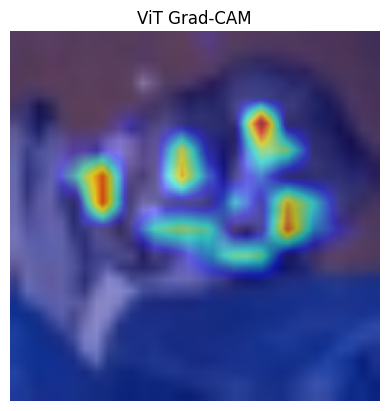

In [49]:
## 8. Grad-CAM Visualization

# Select a random image from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0].unsqueeze(0).to(device)

resized_img = torch.nn.functional.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
input_tensor = transform(resized_img[0]).unsqueeze(0).to(device)

# Define Grad-CAM for each model
vit_target_layer = vit_model.blocks[-1].norm1
# swin_target_layer = swin_model.layers[-1].blocks[-1].norm1

vit_cam = GradCAM(model=vit_model, target_layers=[vit_target_layer], reshape_transform=reshape_transform)
# swin_cam = GradCAM(model=swin_model, target_layers=[swin_target_layer], use_cuda=True)

# Generate CAMs
vit_grayscale_cam = vit_cam(input_tensor=input_tensor, targets=None)
# swin_grayscale_cam = swin_cam(input_tensor=img, targets=None)

image_for_vis = denormalize(resized_img[0].cpu(), mean, std).permute(1, 2, 0).numpy()
cam_image = show_cam_on_image(image_for_vis, vit_grayscale_cam[0], use_rgb=True)

# === 7. 顯示圖像 ===
plt.imshow(cam_image)
plt.title("ViT Grad-CAM")
plt.axis('off')
plt.show()

# # Visualize
# def visualize_cam(grayscale_cam, img):
#     cam = show_cam_on_image(img, grayscale_cam, use_rgb=True)
#     plt.imshow(cam)
#     plt.show()

# print("Vision Transformer Grad-CAM")
# visualize_cam(vit_grayscale_cam, image_for_vis)
# print("SWIN Transformer Grad-CAM")
# visualize_cam(swin_grayscale_cam[0], images[0])

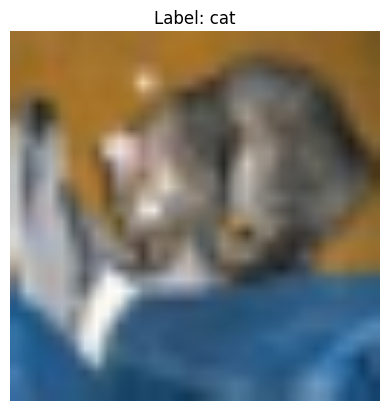

In [50]:
img_single = images[0]

# 反標準化
img_denorm = denormalize(img_single, mean, std)

# 轉換成 numpy 並顯示
plt.imshow(img_denorm.permute(1, 2, 0).numpy())
plt.title(f"Label: {classes[labels[0].item()]}")
plt.axis('off')
plt.show()

c:\Users\user\anaconda3\envs\dl_final\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


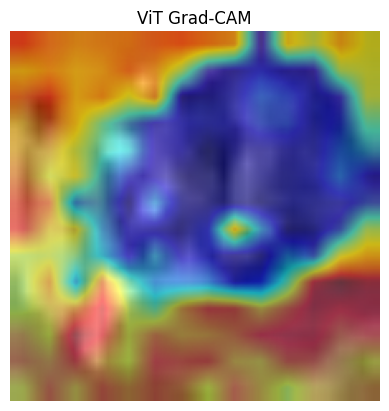

In [28]:
# ## 8. Grad-CAM Visualization

# # Select a random image from the test set
# dataiter = iter(testloader)
# images, labels = next(dataiter)
# img = images[0].unsqueeze(0).to(device)
# vit_model.eval().to(device)

# # ====== Step 1: Hook 註冊 ======
# features = []
# grads = []

# def forward_hook(module, input, output):
#     features.append(output)

# def backward_hook(module, grad_in, grad_out):
#     grads.append(grad_out[0])



# # Define Grad-CAM for each model
# vit_target_layer = vit_model.blocks[-1].attn.proj
# handle_f = vit_target_layer.register_forward_hook(forward_hook)
# handle_b = vit_target_layer.register_backward_hook(backward_hook)
# # swin_target_layer = swin_model.layers[-1].blocks[-1].norm1

# # ====== Step 2: 前向傳遞與 backward ======
# output = vit_model(img)
# class_idx = output.argmax(dim=1).item()
# score = output[0, class_idx]
# vit_model.zero_grad()
# score.backward()

# # ====== Step 3: 計算 CAM ======
# feature_map = features[0]         # shape: [1, 197, 768]
# gradient = grads[0]               # shape: [1, 197, 768]

# weights = gradient.mean(dim=1, keepdim=True)  # [1, 1, 768]
# cam = torch.bmm(feature_map, weights.transpose(1, 2)).squeeze()

# cam = cam[1:]  # 移除 [CLS] token
# cam = cam.reshape(14, 14).cpu().detach().numpy()
# cam = (cam - cam.min()) / (cam.max() - cam.min())


# # vit_cam = GradCAM(model=vit_model, target_layers=[vit_target_layer])
# # swin_cam = GradCAM(model=swin_model, target_layers=[swin_target_layer])



# # Generate CAMs
# # vit_grayscale_cam = vit_cam(input_tensor=img, targets=None)
# # swin_grayscale_cam = swin_cam(input_tensor=img, targets=None)

# def denormalize(tensor, mean, std):
#     """
#     將 Tensor 反標準化並裁切到 [0, 1] 範圍
#     """
#     for t, m, s in zip(tensor, mean, std):
#         t.mul_(s).add_(m)
#     return torch.clamp(tensor, 0, 1)

# # Visualize
# def visualize_cam(grayscale_cam, img):
#     mean= [0.4914, 0.4822, 0.4465]
#     std=[0.2023, 0.1994, 0.2010]
#     img = img.clone().cpu()
#     img = denormalize(img, mean, std)
#     img_np = img.permute(1, 2, 0).numpy()
#     cam = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
#     plt.imshow(cam)
#     plt.show()

# image_vis = denormalize(images[0].clone().cpu(), mean, std).permute(1, 2, 0).numpy()
# image_resized = cv2.resize(image_vis, (224, 224))
# cam_resized = cv2.resize(cam, (224, 224))

# heatmap = show_cam_on_image(image_resized, cam_resized, use_rgb=True)

# plt.imshow(heatmap)
# plt.title("ViT Grad-CAM")
# plt.axis('off')
# plt.show()

# # 移除 hook
# handle_f.remove()
# handle_b.remove()


# # print("Vision Transformer Grad-CAM")
# # visualize_cam(vit_grayscale_cam[0], images[0])
# # print("SWIN Transformer Grad-CAM")
# # visualize_cam(swin_grayscale_cam[0], images[0])